# Adaboost [classifier + regressor] from scratch

## Import statements

In [1]:
import numpy as np
import pandas as pd

## Load and prepare data

In [2]:
df = pd.read_csv("Iris.csv")
df = df.drop("Id", axis=1)
df = df.rename(columns={"species": "label"})

In [3]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# Types of lables
df['label'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [5]:
# Frequency plot
df['label'].value_counts().plot(kind='bar')

## Helper functions

In [6]:
def train_test_split(df, test_size=0.8, random_state=None):
    train_df = df.sample(frac=test_size, random_state=random_state)
    test_df = df[~df.index.isin(train_df.index)]
    return train_df.sort_index(), test_df.sort_index()

In [7]:
def accuracy_score_classification(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

In [8]:
def accuracy_score_regression(y_true, y_pred):
    rmse = np.sqrt(np.sum((y_true - y_pred)**2) / len(y_true)) # RMSE
    return rmse

## Algorithm Classes

- DecisionStump()
- BaseBoostingAlgorithm()
- AdaBoostClassifier()
- AdaBoostRegressor()

In [9]:
class DecisionStump():
    def __init__(self):
        # Feature/Attribute Index to consider for splitting
        self.decision_feature_index = None
        # Exact value from Feature/Attribute to split on
        self.decision_threshold_value = None
        # Stump importance / weight
        self.weight = None
        # Stump error
        self.error = None
        # Left leaf value
        self.left_leaf_value = None
        # Right leaf value
        self.right_leaf_value = None
        # Stump decision compartor 
        self.decision_comparator = None
        print("New Stump Created!")

In [10]:
class BaseBoostingAlgorithm():
    def __init__(self, n_learners):
        self.n_learners = n_learners
        
    def fit(self, X, y):
        # Store all weak learners (Weak learner -> A decsion stump)
        self.learners = []
        # Identify each feature type in input X and store as list
        self.feature_types = self._determine_type_of_feature(X)
        # Concatenate input and output
        self.data = np.concatenate((X, np.expand_dims(y, axis=1)), axis=1)
        # Initialize weight for each example as 1/N (where N -> total number of examples)
        self.sample_weight = np.full(len(self.data), (1 / len(self.data)))
        
        print(self.learners)
        print(self.feature_types)
        print(self.ml_task)
        
        # Iterate and build learners
        for i_boost in range(self.n_learners):
            # Instantiate a new decision stump object
            learner = DecisionStump()

            # Find and Perform split over best feature 
            potential_splits = self._get_potential_splits(self.data)
            split_column_index, split_value = self._determine_best_split(self.data, potential_splits, self.ml_task)
            left_node_data, right_node_data = self._split_data(self.data, split_column_index, split_value)
            print(f'split_column_index: {split_column_index}, split_value: {split_value}')

            # Compute Leaf values
            left_leaf_value = self._create_leaf(left_node_data, self.ml_task)
            right_leaf_value = self._create_leaf(right_node_data, self.ml_task)
            print(f'Left leaf: {left_leaf_value}, Right leaf: {right_leaf_value}')

            # Allocate the instantiated learner with our computed values
            learner.decision_feature_index = split_column_index
            learner.decision_threshold_value = split_value
            learner.left_leaf_value = left_leaf_value
            learner.right_leaf_value = right_leaf_value
            learner.decision_comparator = self.feature_types[split_column_index]
            
            # Boosting step
            self.sample_weight, learner = self.boost(i_boost,
                                              self.data,
                                              self.sample_weight,
                                              learner)
            # Early Termination
            if self.sample_weight is None:
                break
            # Stop boosting since error is 0
            # Stop if the sum of sample weights has become non-positive
            if learner.error == 0 or np.sum(self.sample_weight) <= 0:
                self.learners.append(learner)
                break
            print(f'{i_boost}: Sample weight(sum) {np.sum(self.sample_weight)}')
            # Dont perform operations in below conditional block if we are on final learner
            if not i_boost == self.n_learners - 1:
                # Normalize
                self.sample_weight /= np.sum(self.sample_weight)
                # Construct new data set sample based on sample_weight
                self.data = self._sample_data_by_weights(self.data, self.sample_weight)
                # Reinitialize equal sample weights for the new data
                self.sample_weight = np.full(len(self.data), (1 / len(self.data)))
            
            # Add this learner to our main list of learners
            self.learners.append(learner)
            print(f'Total stumps: {len(self.learners)}')
            
        return self  
            
    def stump_predict(self, data, learner):
        """
        Computes prediction for the passed data examples w.r.t to the learner(descision stump) 
        """
        preds = []
        feature_column = data[:, learner.decision_feature_index]
        for value in feature_column:
            if learner.decision_comparator == 'categorical':
                if value == learner.decision_threshold_value: # Left node
                    pred = learner.left_leaf_value
                else: # right node
                    pred = learner.right_leaf_value
            else: # continuous
                if value <= learner.decision_threshold_value: # Left node
                    pred = learner.left_leaf_value
                else: # right node
                    pred = learner.right_leaf_value
            preds.append(pred)
        return preds
    
    def _sample_data_by_weights(self, data, sample_weight):
        """
        Construct an new input, iteratively sampled over distribution 
        formed by passed sample_weight.

        Note: 
        Learn more about this technique: https://youtu.be/LsK-xG1cLYA (Statquest)
        """
        n_samples, _ = np.shape(data)
        # Intialize array to hold sampled index  
        sampled_indices = []
        # Perform cumulative summation over sample_weight to create buckets
        sample_weight_buckets = np.cumsum(sample_weight)
        # Keeping sampling 'n_samples' times
        for _ in range(n_samples):
            # Generate a random number between 0 and 1
            random_num = np.random.random_sample()
            # Find the bucket Eg: weight buckets [0.33, 0.66, 0.99] and random number = 0.47
            # then index 1 will be selected (since cumsum value is 0.66)
            bucket_index = np.where(sample_weight_buckets > random_num)[0][0]

            sampled_indices.append(bucket_index)
        # finally construct weighted data using sampled_indexes
        weighted_data = data[sampled_indices]

        return weighted_data


    def _get_potential_splits(self, data):
        """
        Get all potential splits for each feature
        Splits can be made on each unique value
        Can essentially make a split at each unique value
        
        """
        potential_splits = {}
        _, n_columns = data.shape
        for column_index in range(n_columns - 1): # excluding the last column which is the label
            values = data[:, column_index]
            unique_values = np.unique(values)

            potential_splits[column_index] = unique_values

        return potential_splits
    
    
    def _calculate_gini_index(self, data):
        """
        Calculate gini index
        """
        label_column = data[:, -1]
        _, counts = np.unique(label_column, return_counts=True)

        probabilities = counts / counts.sum()
        gini_impurity = - (1 + sum(probabilities**2))

        return gini_impurity
    
    
    def _calculate_mse(self, data):
        """
        Calculate mean squared error
        """
        actual_values = data[:, -1]
        if len(actual_values) == 0:   # empty data
            mse = 0

        else:
            prediction = np.mean(actual_values)
            mse = np.mean((actual_values - prediction) **2)

        return mse
    
    
    def _calculate_overall_metric(self, left_node_data, right_node_data, metric_function):
        """
        Generalized impurity metric, computes weighted overall
        impurity/error w.r.t left and right nodes
        """
        n = len(left_node_data) + len(right_node_data)
        # Probabilities of left and right node
        prob_node_left = len(left_node_data) / n
        prob_node_right = len(right_node_data) / n

        overall_metric =  (prob_node_left * metric_function(left_node_data) 
                         + prob_node_right * metric_function(right_node_data))
        
        print(f'prob_node_left * w_i(left_node_data)): {prob_node_left} * {metric_function(left_node_data)} = {(prob_node_left * metric_function(left_node_data))}')
        print(f'prob_node_right * w_i(right_node_data)): {prob_node_right} * {metric_function(right_node_data)} = {(prob_node_right * metric_function(right_node_data))}')
        

        return overall_metric
    
    def _determine_best_split(self, data, potential_splits, ml_task):
        """
        Iterate over each column_index (as keys) in potential_split (dict)
        Perform split(of examples) over each unique value and evaluate the split
        Identify the best split and return its feature index and value
        """
        
        # Best minimum gini index to be updated iteratively
        best_overall_metric = float('inf')
        
        for column_index in potential_splits:
            for value in potential_splits[column_index]:
                left_node_data, right_node_data = self._split_data(data, split_column_index=column_index, split_value=value)

                if ml_task == "regression":
                    current_overall_metric = self._calculate_overall_metric(left_node_data, right_node_data,
                                                                                     metric_function=self._calculate_mse)
                else: # classification
                    current_overall_metric = self._calculate_overall_metric(left_node_data, right_node_data,
                                                                                     metric_function=self._calculate_gini_index)
                
                # If a lower overall_metric is achieved update the index and value with the current
                #print(column_index, value, current_overall_metric)
                if current_overall_metric <= best_overall_metric:
                    best_overall_metric = current_overall_metric
                    best_split_column_index = column_index
                    best_split_value = value

        return best_split_column_index, best_split_value
    
    
    def _split_data(self, data, split_column_index, split_value):
        """ 
        Split data(examples) based on best split_column_index and split_value
        estimated using task specific splitting metric.
        """
        # Get values(from feature column) for the passed split_column index
        split_column_values = data[:, split_column_index]

        type_of_feature = self.feature_types[split_column_index]
        if type_of_feature == "continuous":
            left_node_data = data[split_column_values <= split_value]
            right_node_data = data[split_column_values >  split_value]

        # feature is categorical   
        else:
            left_node_data = data[split_column_values == split_value]
            right_node_data = data[split_column_values != split_value]

        return left_node_data, right_node_data
    
    
    def _create_leaf(self, data, ml_task):
        """
        Create leaf node, with leaf value based on ml_task
        for,
        Classfication: consider majority vote
        Regression: consider the mean value
        """
        label_column = data[:, -1]
        if ml_task == "regression":
            leaf = np.mean(label_column)

        # classfication    
        else:
            unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
            index = counts_unique_classes.argmax()
            leaf = unique_classes[index]

        return leaf
    
    
    def _determine_type_of_feature(self, X):
        """
        Determine, if the feature is categorical or continuous
        """
        feature_types = []
        n_unique_values_treshold = 15 # Threshold for a numeric feature to be categorical
        
        n_samples, n_features = np.shape(X)
        
        for feature_i in range(n_features):
            unique_values = np.unique(X[:, feature_i])
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")

        return feature_types
    

In [11]:
class AdaBoostClassifier(BaseBoostingAlgorithm):
    def __init__(self, n_learners=20):
        # Set total number of weak learners
        super().__init__(n_learners)
        self.ml_task = "classification"
        self.classes = None
        self.n_classes = None
        
    def boost(self, i_boost, data, sample_weight, learner):
        """
        Compute learner importance and error, along with boosted weights for each example 
        """
        print(f'Boost Called')
        
        # If its first boost initialize number of classes(n_classes)
        if i_boost == 0:
            self.classes = np.unique(data[:, -1])
            self.n_classes = self.classes.size
        
        # Perform predictions
        preds = self.stump_predict(self.data, learner)
        
        # Incorrectly classified examples
        incorrect = preds != data[:, -1]
        
        # Learner Error
        learner_error = np.mean(np.average(incorrect, weights=sample_weight, axis=0))
        # Stop if classification is perfect
        if learner_error <= 0:
            learner.weight = 1
            learner.error = 0
            return sample_weight, learner
        print(f'Learner error: {learner_error}')
        
        # Learner weight
        learner_weight = (np.log((1 - learner_error) / learner_error) +
                        np.log(self.n_classes - 1))
        print(f'Learner weight: {learner_weight}')
        
        # Boost sample_weight for each each sample
        # Dont boost sample_weight if we are on final learner
        if not i_boost == self.n_learners - 1:
        # Boost only positive weights
        #print(f'#### Sample Weights before')
        #print(sample_weight)
            sample_weight *= np.exp(learner_weight * incorrect *
                                    ((sample_weight > 0) |
                                     (learner_weight < 0)))
        
        #print(f'#### Sample Weights After')
        #print(sample_weight)
        # Allocate learner its computed weight and error
        learner.weight = learner_weight
        learner.error = learner_error
        
        # Finally return sample weights and boosted learner
        return sample_weight, learner
         
    def predict(self, X):
        """
        Predict classes for X.
        """
        print(f'Predict called')
        
        # Get activated matrix for with respect to each learner [get vote of each learner]
        # Add each activated matrix (matrix addition) [get overall vote of all leaners]
        # return the overall matrix
        # Argmax is used over each row of overall matrix to figure our the class
        classes = self.classes[:, np.newaxis]
        pred = sum((self.stump_predict(X, learner) == classes).T * learner.weight
                   for learner in self.learners)
        # Normalize 
        learner_weights = sum(learner.weight for learner in self.learners)
        pred /= learner_weights
        
        # If its binary classification obatin the form [-, +], convienient to select classes with np.take() 
        # Eg(binary): classes =  [[c1], [c2]] and pred = [True, False, True], below output: [[c2], [c1], [c2]]
        if self.n_classes == 2:
            pred[:, 0] *= -1
            pred = pred.sum(axis=1)
            return classes.take(pred > 0, axis=0)
        # Finds index of column with max value, and uses this index to select class from classes
        #print(f'Classes ({classes.shape}): {classes}')
        #print(f'Classes ({pred.shape}): {pred}')
        #print(f'Classes element ({pred[0].shape}): {pred}')
        return classes.take(np.argmax(pred, axis=1), axis=0)
        

In [98]:
sum(i for i in range(4))

6

In [39]:
xg = np.array([1, 2, 3])

In [55]:
np.exp(xg)

array([ 2.71828183,  7.3890561 , 20.08553692])

In [67]:
xg[:, np.newaxis]

array([[1],
       [2],
       [3]])

In [88]:
xgg = np.array(['a', 'b', 'c'])
xgg = xgg[:, np.newaxis]
xgg

array([['a'],
       ['b'],
       ['c']], dtype='<U1')

In [82]:
xgp = np.array(['a', 'b', 'b'])
xgp

array(['a', 'b', 'b'], dtype='<U1')

In [90]:
(xgp == xgg)

array([[ True, False, False],
       [False,  True,  True],
       [False, False, False]])

In [91]:
(xgp == xgg).T

array([[ True, False, False],
       [False,  True, False],
       [False,  True, False]])

In [95]:
((xgp == xgg).T * 2)

array([[2, 0, 0],
       [0, 2, 0],
       [0, 2, 0]])

In [114]:
sum([((xgp == xgg).T * 2), ((xgp == xgg).T * 2)])

array([[4, 0, 0],
       [0, 4, 0],
       [0, 4, 0]])

In [87]:
np.sum((xgp == xgg) * 2)

4

In [58]:
sum((xgp == xgg).T * 2)

array([2, 2, 2])

In [116]:
vtt = np.array([[2, 0, 0], [0, 2, 2]]).T
vtt

array([[2, 0],
       [0, 2],
       [0, 2]])

In [117]:
vtt[:, 0] *= -1

In [118]:
vtt

array([[-2,  0],
       [ 0,  2],
       [ 0,  2]])

In [120]:
vtt.sum(axis=1) > 0

array([False,  True,  True])

In [125]:
cs = np.array([['class1'], ['class2']])

In [126]:
cs.take([False, True, False, True, True], axis=0)

array([['class1'],
       ['class2'],
       ['class1'],
       ['class2'],
       ['class2']], dtype='<U6')

In [313]:
class AdaBoostRegressor():
    pass

In [ ]:
1/4 * True * (1/2 > 0) * (-1 < 0)

In [14]:
abc = AdaBoostClassifier(30)

In [15]:
wdd = abc.fit(df.iloc[:, :-1].values, df.iloc[:, -1].values)

[]
['continuous', 'continuous', 'continuous', 'continuous']
classification
New Stump Created!
prob_node_left * w_i(left_node_data)): 0.006666666666666667 * -2.0 = -0.013333333333333334
prob_node_right * w_i(right_node_data)): 0.9933333333333333 * -1.3333633620107204 = -1.324474272930649
prob_node_left * w_i(left_node_data)): 0.02666666666666667 * -2.0 = -0.05333333333333334
prob_node_right * w_i(right_node_data)): 0.9733333333333334 * -1.33383373991368 = -1.2982648401826484
prob_node_left * w_i(left_node_data)): 0.03333333333333333 * -2.0 = -0.06666666666666667
prob_node_right * w_i(right_node_data)): 0.9666666666666667 * -1.334126040428062 = -1.2896551724137932
prob_node_left * w_i(left_node_data)): 0.06 * -2.0 = -0.12
prob_node_right * w_i(right_node_data)): 0.94 * -1.3360494944922288 = -1.255886524822695
prob_node_left * w_i(left_node_data)): 0.07333333333333333 * -2.0 = -0.14666666666666667
prob_node_right * w_i(right_node_data)): 0.9266666666666666 * -1.3375084105377568 = -1.23942

In [39]:
predicc = wdd.predict(df.iloc[:, :-1].values)

Predict called


In [40]:
accuracy_score_classification(df.iloc[:, -1].values, predicc[:, -1])

0.94

In [82]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

In [92]:
clf = AdaBoostClassifier(n_estimators=1)

In [93]:
clf.fit(df.iloc[:, :-1].values, df.iloc[:, -1].values)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=1, random_state=None)

In [94]:
sk_pred = clf.predict(df.iloc[:, :-1].values)

In [95]:
accuracy_score_classification(df.iloc[:, -1].values, sk_pred)

0.6666666666666666

In [ ]:
wdddf['label'].value_counts().plot(kind='bar')

In [20]:
import matplotlib.pyplot as plt

In [38]:
np.unique(df.values[:, -1], return_counts=True)

(array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object),
 array([50, 50, 50], dtype=int64))

In [36]:
np.unique(wdd[:, -1], return_counts=True)

(array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object),
 array([30, 21, 99], dtype=int64))

In [17]:
np.histogram(wdd[:, -1])

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [17]:
np.unique(df.values[:, -1]).size

3

In [33]:
ft = df.values[:, -1][:3] == ['Iris-setos', 'Iris-setosa', 'Iris-setosa']
np.mean(np.average(ft, weights=np.array([0.2, 0.4, 0.4]), axis=0))

0.8

In [23]:
np.mean(ft)

1.0

In [19]:
data = datasets.load_digits()
y = data.target

In [315]:
class ABC():
    def __init__(self, name):
        self.name = name
        print('Instantiate:',  name)
    def print_myname(self, myname):
        print("My name is", myname)
        self.predict()
    def hello1(self):
        print('h1')
    def hello2(self):
        self.hello1()
        
    def a2(self, name):
        print('a2', name)
    def a3(self, name):
        print('a3', name)
    def az(self, m_func):
        m_func('pratik')
        
    def func_mix(self):
        self.az(m_func=self.a2)
        self.az(m_func=self.a3)

In [316]:
class A(ABC):
    def __init__(self, name):
        super().__init__(name)
    def something_about_me(self, name):
        self.print_myname(name)
    def predict(self):
        print('predicted')

In [317]:
stored = A('A')

Instantiate: A


In [318]:
stored.something_about_me('pratik')

My name is pratik
predicted


In [319]:
stored.print_myname('pratik')

My name is pratik
predicted


In [320]:
stored.func_mix()

a2 pratik
a3 pratik


In [321]:
stored.a2()

TypeError: a2() missing 1 required positional argument: 'name'

In [72]:
np.unique(X[:, feature_i])

NameError: name 'X' is not defined

In [164]:
tf = np.array([
       [2, 4, 1, 1, 0],
       [5, 2, 1, 0, 0],
       [0, 8, 0, 1, 2]])

In [165]:
np.unique(tf[:, 2], return_index=True)

(array([0, 1]), array([2, 0], dtype=int64))

In [23]:
np.concatenate((df.iloc[:, :-1].values, df.iloc[:, -1].values), axis=1)

ValueError: all the input arrays must have same number of dimensions

In [166]:
# np.concatenate((df.iloc[:, :-1].values, np.expand_dims(df.iloc[:, -1].values, axis=1)), axis=1)

In [26]:
df.iloc[:, :-1].values.shape

(150, 4)

In [27]:
df.iloc[:, -1].values.shape

(150,)

In [167]:
# np.expand_dims(df.iloc[:, -1].values, axis=1)

In [225]:
vt = np.cumsum(np.array([0.33, 0.33, 0.33]))
vt

array([0.33, 0.66, 0.99])

In [226]:
ide = np.random.random_sample()
ide

0.47607097125121944

In [264]:
idr = np.array([[1, 1, 2, 1], [22, 1, 2, 1], [33, 1, 2, 1], [44, 1, 2, 1], [55, 1, 2, 1]])
idr

array([[ 1,  1,  2,  1],
       [22,  1,  2,  1],
       [33,  1,  2,  1],
       [44,  1,  2,  1],
       [55,  1,  2,  1]])

In [265]:
idd = [0, 0, 1, 2, 2]

In [266]:
idr[idd]

array([[ 1,  1,  2,  1],
       [ 1,  1,  2,  1],
       [22,  1,  2,  1],
       [33,  1,  2,  1],
       [33,  1,  2,  1]])

In [267]:
sw = np.array([0.4, 0.1, 0.1, 0.2, 0.2])

In [278]:
np.cumsum(sw)

array([0.4, 0.5, 0.6, 0.8, 1. ])

In [304]:
def sample_data_by_weight(data, sample_weight):
    """
    Construct an new input, iteratively sampled over distribution 
    formed by passed sample_weight.
    
    Note: 
    Learn more about this technique: https://youtu.be/LsK-xG1cLYA (Statquest)
    """
    n_samples, _ = np.shape(data)
    # Intialize array to hold sampled index  
    sampled_indices = []
    # Perform cumulative summation over sample_weight to create buckets
    sample_weight_buckets = np.cumsum(sample_weight)
    # Keeping sampling 'n_samples' times
    for _ in range(n_samples):
        # Generate a random number between 0 and 1
        random_num = np.random.random_sample()
        # Find the bucket Eg: weight buckets [0.33, 0.66, 0.99] and random number = 0.47
        # then index 1 will be selected (since cumsum value is 0.66)
        bucket_index = np.where(sample_weight_buckets > random_num)[0][0]
        
        sampled_indices.append(bucket_index)
    # finally construct weighted data using sampled_indexes
    weighted_data = data[sampled_indices]
    
    return weighted_data

In [305]:
sample_data_by_weight(idr, sw)

array([[ 1,  1,  2,  1],
       [ 1,  1,  2,  1],
       [ 1,  1,  2,  1],
       [ 1,  1,  2,  1],
       [55,  1,  2,  1]])

In [254]:
np.where(vt > ide)[0][0]

1

In [206]:
import matplotlib.pyplot as plt
import random

In [207]:
stf = [np.random.random_sample() for i in range(100)] 
stfr = [random.uniform(0, 1) for i in range(100)] 

(array([14.,  9., 11.,  6., 15.,  6., 14.,  7.,  7., 11.]),
 array([0.00696925, 0.10549445, 0.20401964, 0.30254484, 0.40107003,
        0.49959522, 0.59812042, 0.69664561, 0.79517081, 0.893696  ,
        0.9922212 ]),
 <a list of 10 Patch objects>)

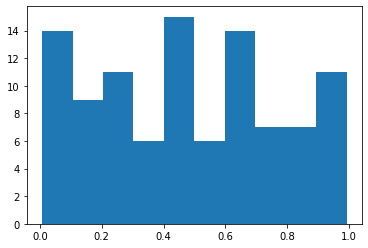

In [208]:
plt.hist(stf)

(array([12., 14., 10.,  8.,  5., 10.,  6., 12., 10., 13.]),
 array([9.60159013e-04, 9.95832402e-02, 1.98206321e-01, 2.96829402e-01,
        3.95452484e-01, 4.94075565e-01, 5.92698646e-01, 6.91321727e-01,
        7.89944808e-01, 8.88567889e-01, 9.87190971e-01]),
 <a list of 10 Patch objects>)

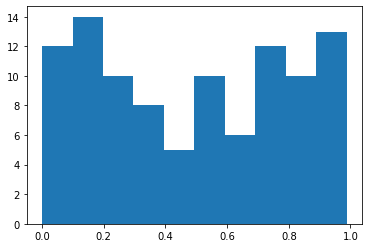

In [209]:
plt.hist(stfr)